# Load Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ai-vs-human-text' dataset.
Path to dataset files: /kaggle/input/ai-vs-human-text


In [ ]:
import pandas as pd
import os

file_path = os.path.join(path, 'AI_Human.csv')

df = pd.read_csv(file_path)

df.head()

# 0 -> Human
# 1 -> AI

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


# EDA

In [ ]:
df = df.rename(columns={'generated': 'labels'})

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset basic info

In [ ]:
print("\n--- Basic info ---")
df.info()

print("\n--- Missing value detection ---")
print(df.isnull().sum())

print("\n--- Duplicate value detection ---")
print(f"Duplicate number: {df.duplicated().sum()}")


--- Basic info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    487235 non-null  object 
 1   labels  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB

--- Missing value detection ---
text      0
labels    0
dtype: int64

--- Duplicate value detection ---
Duplicate number: 0


In [ ]:
label_col = 'labels'

print("\n--- Category Statistics ---")
print(df[label_col].value_counts())


--- Category Statistics ---
labels
0.0    305797
1.0    181438
Name: count, dtype: int64


Label Distribution

/tmp/ipython-input-607896369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=label_col, palette="coolwarm")


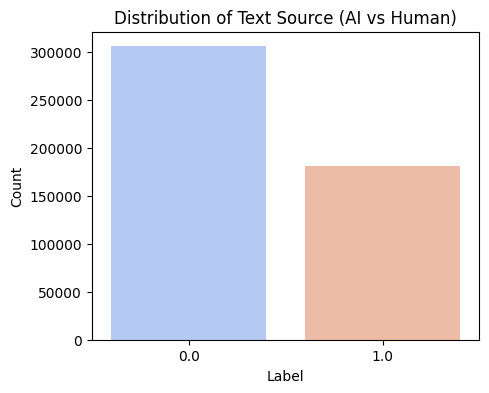

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(data=df, x=label_col, palette="coolwarm")
plt.title("Distribution of Text Source (AI vs Human)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Text Length Distribution


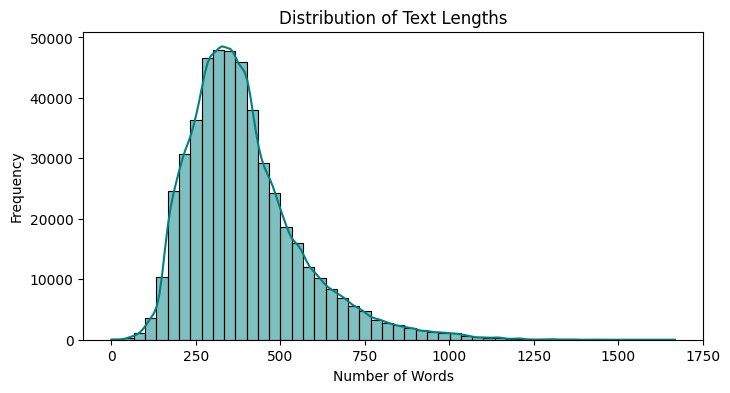


Average text length: 393.1
Maximum text length: 1668


In [ ]:
text_col = 'text'
df['text_length'] = df[text_col].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=50, kde=True, color='teal')
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

print("\nAverage text length:", round(df['text_length'].mean(), 2))
print("Maximum text length:", df['text_length'].max())

In [ ]:
print(df.groupby(label_col)['text_length'].describe())

           count       mean         std   min    25%    50%    75%     max
labels                                                                    
0.0     305797.0  421.98518  186.870962  14.0  281.0  389.0  520.0  1668.0
1.0     181438.0  344.40653  117.031491   0.0  274.0  337.0  403.0  1238.0


# Preprocessing

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df[text_col].apply(clean_text)

# print("\n原始文本示例:\n", df[text_col].iloc[0])
# print("\n清洗后文本示例:\n", df['clean_text'].iloc[0])

# Data split


--- Results of dataset split ---
train: (341064, 4), val: (73085, 4), test: (73086, 4)


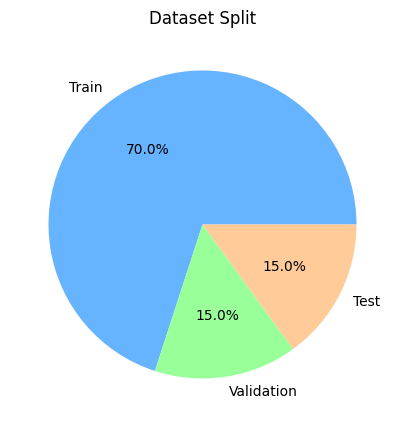

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[label_col])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[label_col])

print("\n--- Results of dataset split ---")
print(f"train: {train_df.shape}, val: {val_df.shape}, test: {test_df.shape}")

sizes = [len(train_df), len(val_df), len(test_df)]
labels = ['Train', 'Validation', 'Test']
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title("Dataset Split")
plt.show()

# Model

In [ ]:
!pip install -q transformers datasets evaluate accelerate

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
train_ds = Dataset.from_pandas(train_df[['clean_text','labels']])
val_ds = Dataset.from_pandas(val_df[['clean_text','labels']])
test_ds = Dataset.from_pandas(test_df[['clean_text','labels']])

Define Evaluation Metrics

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)['accuracy'],
        "f1": f1.compute(predictions=preds, references=labels, average='macro')['f1']
    }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Define Train function

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = {
    "bert": "bert-base-uncased",
    "deberta": "microsoft/deberta-v3-base",
    "DistilBERT": "distilbert-base-uncased",
    "MiniDeBERTa": "microsoft/deberta-v3-small"
}

num_labels = 2
num_epochs = 3
batch_size = 4
learning_rate = 2e-5

In [ ]:
train_dataset_small = train_ds.shuffle(seed=42).select(range(int(0.01 * len(train_ds))))
val_dataset_small = val_ds.shuffle(seed=42).select(range(int(0.01 * len(val_ds))))
print(f"use {len(train_dataset_small)} train samples and {len(val_dataset_small)} val samples")
train_loader = DataLoader(train_dataset_small, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_small, batch_size=batch_size)

use 3410 train samples and 730 val samples


In [ ]:
def train_model(model_name):
    print(f"\n===== Training {model_name} =====")
    tokenizer = AutoTokenizer.from_pretrained(model_names[model_name])
    model = AutoModelForSequenceClassification.from_pretrained(model_names[model_name], num_labels=num_labels).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_train_acc = 0, 0
        for batch in train_loader:
            # Tokenize the text data
            inputs = tokenizer(batch['clean_text'], padding=True, truncation=True, return_tensors="pt").to(device)
            # Ensure labels are of type torch.long
            inputs['labels'] = batch['labels'].long().to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_train_acc += accuracy_score(inputs["labels"].cpu(), preds.cpu())

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)

        model.eval()
        total_val_loss, total_val_acc = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                # Tokenize the text data
                inputs = tokenizer(batch['clean_text'], padding=True, truncation=True, return_tensors="pt").to(device)
                # Ensure labels are of type torch.long
                inputs['labels'] = batch['labels'].long().to(device)

                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                total_val_acc += accuracy_score(inputs["labels"].cpu(), preds.cpu())

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f}")

    if num_epochs > 0: # Check if there is data to plot
        epochs = range(1, num_epochs + 1)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        if num_epochs == 1: # Plot as points for a single epoch
            plt.plot(epochs, train_losses, 'bo', label='Train Loss')
            plt.plot(epochs, val_losses, 'ro', label='Val Loss')
        else: # Plot as lines for multiple epochs
            plt.plot(epochs, train_losses, 'b-', label='Train Loss')
            plt.plot(epochs, val_losses, 'r-', label='Val Loss')
        plt.title(f'{model_name.upper()} Loss vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        if num_epochs == 1: # Plot as points for a single epoch
            plt.plot(epochs, train_accs, 'bo', label='Train Acc')
            plt.plot(epochs, val_accs, 'ro', label='Val Acc')
        else: # Plot as lines for multiple epochs
            plt.plot(epochs, train_accs, 'b-', label='Train Acc')
            plt.plot(epochs, val_accs, 'r-', label='Val Acc')
        plt.title(f'{model_name.upper()} Accuracy vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close() # Close the plot after showing

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs
    }

# Train & Evaluate


===== Training DistilBERT =====


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Train Loss: 0.2080 | Val Loss: 0.0914 | Train Acc: 0.9223 | Val Acc: 0.9713
Epoch 2/3 | Train Loss: 0.0644 | Val Loss: 0.0803 | Train Acc: 0.9812 | Val Acc: 0.9768
Epoch 3/3 | Train Loss: 0.0258 | Val Loss: 0.0884 | Train Acc: 0.9938 | Val Acc: 0.9740


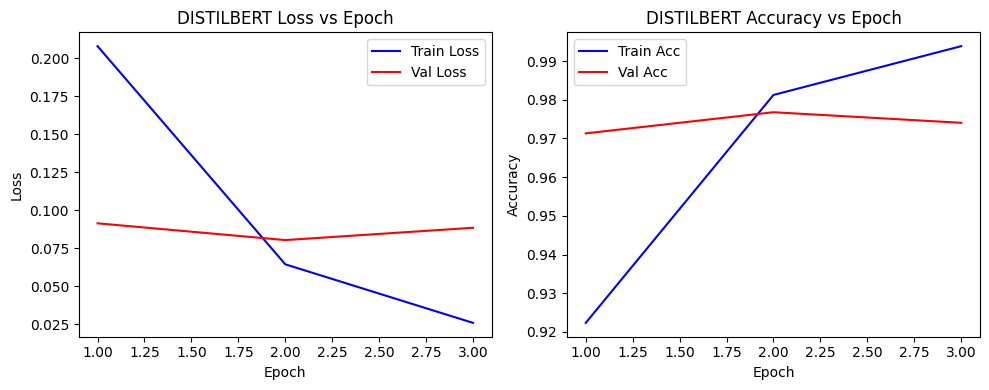

In [ ]:
bert_result = train_model("DistilBERT")


===== Training MiniDeBERTa =====


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/3 | Train Loss: 0.2116 | Val Loss: 0.0701 | Train Acc: 0.9103 | Val Acc: 0.9836
Epoch 2/3 | Train Loss: 0.0542 | Val Loss: 0.0893 | Train Acc: 0.9859 | Val Acc: 0.9768
Epoch 3/3 | Train Loss: 0.0242 | Val Loss: 0.0932 | Train Acc: 0.9938 | Val Acc: 0.9754


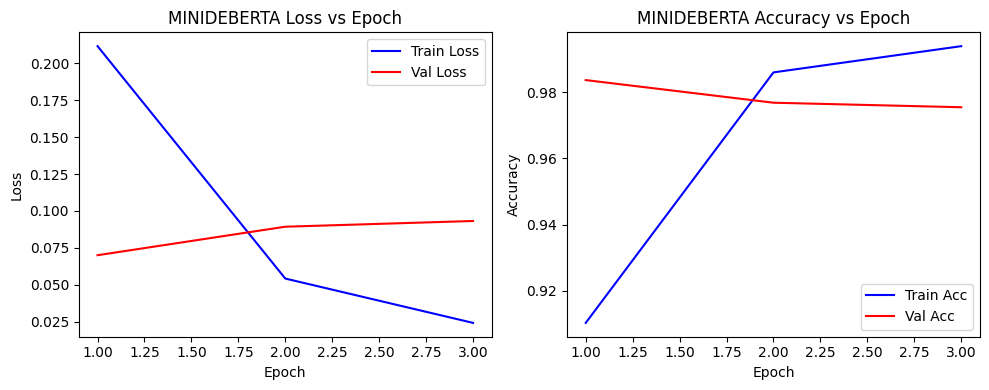

In [ ]:
deberta_result = train_model("MiniDeBERTa")